**Credit Card Fraud Detection with Decision Trees and SVM**

A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).


# Import Libraries & Load the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC

In [5]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
raw_data=pd.read_csv(url)
raw_data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Dataset Analysis

In [8]:
labels = raw_data['Class'].unique()
labels

array([0, 1])

In [9]:
sizes = raw_data['Class'].value_counts().values
sizes

array([284315,    492])

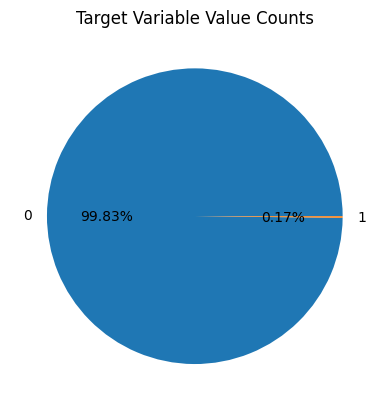

In [10]:
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

the dataset is highly unbalanced -> special attention when training / evaluating a model.

<Axes: >

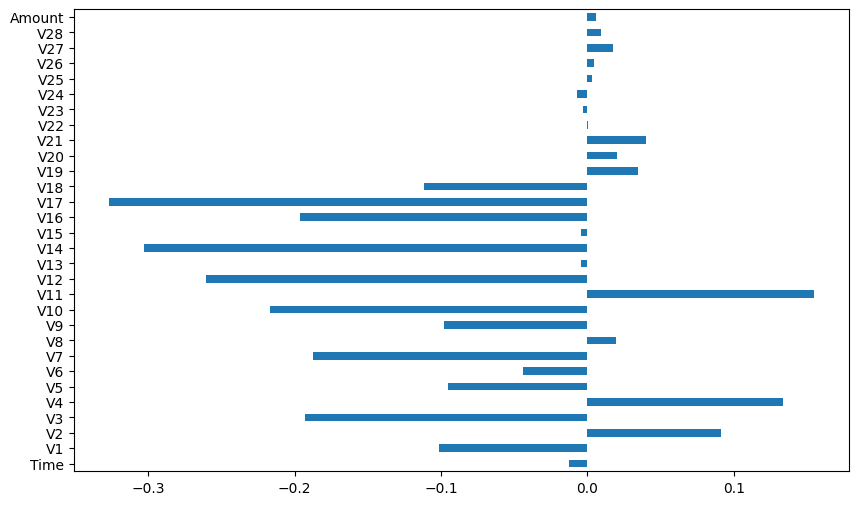

In [22]:
ind_vars_corr = raw_data.corr()['Class'].drop(['Class'])
ind_vars_corr.plot(kind='barh', figsize=(10, 6))

Some features affect the output Class more than the others. We may use only the most correlated features.

# Dataset Preprocessing

In [24]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [40]:
input_feature = raw_data.iloc[:, 1:30] # get col index 1 (V1) -> 29 (Amount)
input_feature.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [65]:
target = raw_data.iloc[:, 30]
target.head(2)

,Class
0,0
1,0


In [60]:
# standardize features, data normalization
stan_scaler = StandardScaler()
raw_data.iloc[:, 1:30] = stan_scaler.fit_transform(raw_data.iloc[:, 1:30])
data_matrix = raw_data.values
# raw_data.values : Pandas DataFrame -> NumPy array.
# data_matrix = raw_data.values -> tất cả các cột của raw_data (bao gồm 'Time' và 'Class') sẽ trở thành các cột trong data_matrix

In [61]:
X = data_matrix[:, 1:30] # V1-Amount
y = data_matrix[:, 30] # Class
X = normalize(X, norm="l1") # L1 (L1-norm)

# L1
# Tính tổng giá trị tuyệt đối của tất cả các số trong mỗi hàng (vector/mẫu dữ liệu).
# Chia mỗi số trong hàng đó cho tổng giá trị tuyệt đối vừa tính được.
# Kết quả: Mỗi hàng mới sẽ có tổng các giá trị tuyệt đối của các phần tử bằng 1.

# Training / Evaluating

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
w_train = compute_sample_weight('balanced', y_train)
# tính trọng số mẫu (sample weights) cho tập y_train
# xử lý vấn đề mất cân bằng lớp (class imbalance)

In [72]:
dt = DecisionTreeClassifier(max_depth=4, random_state=35)
dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

In [73]:
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

In [74]:
# Evaluate the Decision Tree Classifier Models
y_pred_dt = dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


In [75]:
# # Evaluate the SVM
y_pred_svm = svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986
